In [1]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from encoder import Encoder
from decoder import Decoder
from flickr_dataset import *
from utils import *
import matplotlib.pyplot as plt

In [10]:
# Model parameters
data_folder = './processed_data'  
embedding_len = 512  
attention_len = 512  
lstm_len = 512  
caps_per_image=2
batch_size = 32
learning_rate = 4e-4  

# Read word map
word_map_file = os.path.join(data_folder, 'WORDMAP.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

# Decoder model
decoder = Decoder(attention_len=attention_len,
                    embedding_len=embedding_len,
                    features_len=lstm_len,
                    wordmap_len=len(word_map))
# We need an optimiser to update the model weights
grad_params=filter(lambda p: p.requires_grad, decoder.parameters())
decoder_optimizer = torch.optim.Adam(params=grad_params, lr=learning_rate)

# Loss function
criterion = nn.CrossEntropyLoss()

# Dataloaders are wrappers around datasets that help woth the learning.
# Its not mandatory but its usefull so we might as well use it
dataset=FlickrDataset(data_folder, 'DEV', caps_per_image)
data_loader = torch.utils.data.DataLoader(
            FlickrDataset(data_folder, 'DEV', caps_per_image),
            batch_size=5, )

losses=[]
weights=[]
predictions=[]
print('--------------------------------------------- LEARNING STARTED -------------------------------------------')
for epoch in range(1,15):
    print( '----------------------------------- Epoch',epoch,'----------------------------------')
    for i,(imgs,caps,caplens) in enumerate(data_loader):
        #print( '----------------------------------- Batch',i,'----------------------------------')

        scores, caps_sorted, decode_lengths, alphas, sort_ind=decoder.forward(imgs, caps.to(dtype=torch.int64), caplens)
        # Remove the <start> word
        targets = caps_sorted[:, 1:]

        prediction=''
        for line in scores[0]:
            idx=line.argmax()
            for key in word_map.keys():
                if word_map[key]==idx:
                    prediction+=' '+str(key)
        caption=''
        for line in caps[sort_ind[0], 1:caplens[sort_ind[0]]+1]:
            for key in word_map.keys():
                if word_map[key]==line:
                    caption+=' '+str(key)

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)
        #print('loss : ',loss.item())
        decoder_optimizer.zero_grad()
        losses.append(loss)
        loss.backward()
        decoder_optimizer.step()
    predictions.append(prediction)
    weights.append(alphas)    
    #print('--------------------------------------------------------------')
    print('Prediction : ',prediction)
    print('Truth : ',caption)
    #print('--------------------------------------------------------------')    

--------------------------------------------- LEARNING STARTED -------------------------------------------
----------------------------------- Epoch 1 ----------------------------------
Prediction :   a a dog dog a dog dog a a a
Truth :   a brown dog wearing a black collar running across the beach
----------------------------------- Epoch 2 ----------------------------------
Prediction :   a a dog a a a a a a a
Truth :   a brown dog wearing a black collar running across the beach
----------------------------------- Epoch 3 ----------------------------------
Prediction :   a a dog a a dog dog a a a
Truth :   a brown dog wearing a black collar running across the beach
----------------------------------- Epoch 4 ----------------------------------
Prediction :   a dog dog in a dog dog the a the
Truth :   a brown dog wearing a black collar running across the beach
----------------------------------- Epoch 5 ----------------------------------
Prediction :   a dog dog dog a dog dog a a a
Trut

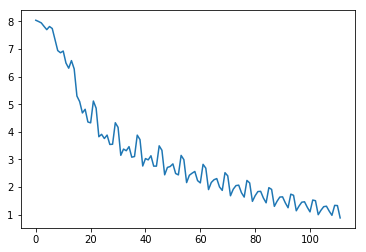

In [11]:
losses=np.array(losses)
plt.plot(losses)

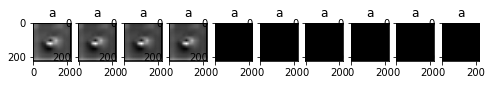

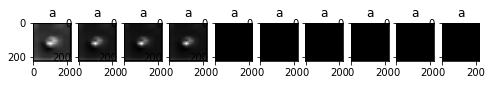

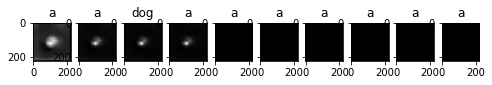

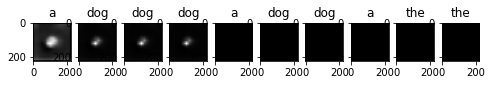

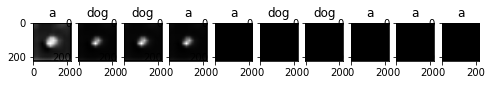

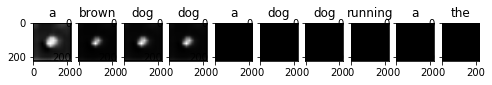

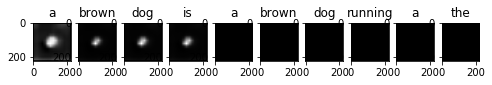

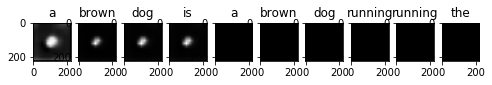

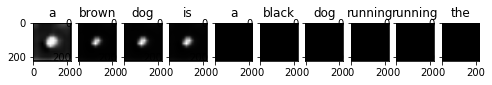

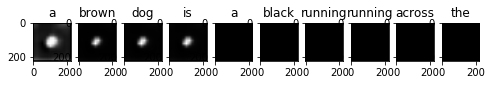

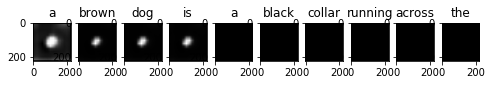

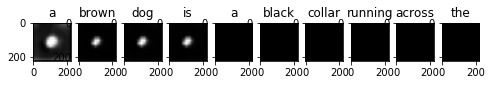

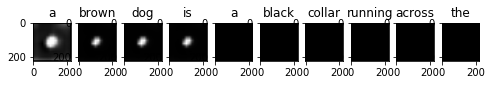

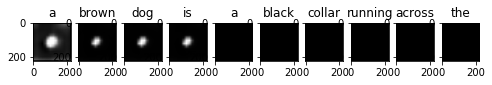

In [9]:
# from skimage.transform import resize
from skimage import io, transform

path='./raw_data/Flickr8k_data/488416045_1c6d903fe0.jpg'
image = io.imread(path)

for i,weight in enumerate(weights):
    plt.figure(i,figsize=(8, 6))
    for j,word in  enumerate(weight[-1]):
        attention=np.array(word.detach()).reshape(14,14)
        attention = resize(attention, (224, 224))
        plt.subplot(1,len(weight[-1]),j+1)
        plt.imshow(image)
        plt.subplots_adjust(hspace = .1)

        plt.imshow(attention,cmap='gray', alpha=1)
        plt.title(predictions[i].split()[j])